This notebook should be run on Google Colab.
<a href="https://colab.research.google.com/github/SavvinaDaniil/UnfairnessOfPopularityBias/blob/main/Movie_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# Process
In this notebook, I will train the movie recommendation algorithms using two different packages: <a href="http://surpriselib.com/">Surprise</a> & <a href="https://cornac.readthedocs.io/en/latest/">Cornac</a>. 

## A. Import lbraries

In [1]:
!pip uninstall tensorflow -y
!pip install tensorflow-gpu==1.15
!apt install --allow-change-held-packages libcudnn7=7.4.1.5-1+cuda10.0

Found existing installation: tensorflow 2.9.2
Uninstalling tensorflow-2.9.2:
  Successfully uninstalled tensorflow-2.9.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 411.5 MB 6.0 kB/s 
     |████████████████████████████████| 3.8 MB 39.1 MB/s 
     |████████████████████████████████| 50 kB 6.2 MB/s 
     |████████████████████████████████| 503 kB 47.8 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=ef2b151ab48ae5267caedbb946f6e7da2819621adc99441faf507fea6ef788c8
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installati

In [2]:
!pip install cornac

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.4 MB 5.4 MB/s 


In [72]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import random as rd
import pandas as pd
import numpy as np
from tqdm import tqdm
import time

# Cornac imports
import cornac
from cornac.eval_methods import RatioSplit
from cornac.data import Reader as CornacReader #Reader exists in both packages
from cornac.models import MostPop, MF, PMF, BPR, NeuMF, WMF, HPF, VAECF, ItemKNN, UserKNN, BaselineOnly 
from cornac.models import NMF as CornacNMF #NMF exists in both packages
from cornac.metrics import MAE, MSE, RMSE, Precision, Recall, NDCG, AUC, MAP, FMeasure, MRR

from collections import defaultdict
from scipy import stats
from numpy.linalg import norm
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
# set plot style: grey grid in the background:
sns.set(style="darkgrid")
pd.set_option("display.precision", 8)

## B. Set hyperparameters
There are certain hyperparameters that need to be tuned before the run. 

In [5]:
# constants and initialization
rating_threshold = 1.0 # needed for the cornac library: Threshold used to binarize rating values into positive or negative feedback for model evaluation using ranking metrics (rating metrics are not affected). 
my_seed = 0
test_size = 0.2 # the percentage of "hold out" data that are used for testing
predict_col = "rating"
user_col = "user"
top_fraction = 0.2 # the amount of items that will be considered "popular"

rd.seed(my_seed) #seed for random functions
np.random.seed(my_seed) #seed for all numpy stuff

## C. Read files

In [6]:
user_events_file = 'https://raw.githubusercontent.com/SavvinaDaniil/UnfairnessOfPopularityBias/main/data/ratings_movies.dat'

# read user events
cols = ['user', 'movie', 'rating', 'timestamp']
df_events = pd.read_table(user_events_file, sep = "::", engine="python", names=cols)
item_col = "movie"
print('No. of user events: ' + str(len(df_events)))

No. of user events: 1000209


In [7]:
df_events.head()

,user,movie,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## D. Data analysis

In [8]:
def users_and_items(df_events, user_col, item_col):
    print('No. user events: ' + str(len(df_events)))
    print('No. items: ' + str(len(df_events[item_col].unique())))
    print('No. users: ' + str(len(df_events[user_col].unique())))
    print("\n")
def user_distribution(df_events, user_col, item_col):
    user_dist = df_events[user_col].value_counts() 
    num_users = len(user_dist)
    print('Mean '+item_col+'s per user: ' + str(np.round(user_dist.mean(),1))) 
    print('Min '+item_col+'s per user: ' + str(np.round(user_dist.min(),1))) 
    print('Max '+item_col+'s per user: ' + str(np.round(user_dist.max(),1)))
    print("\n")
    return user_dist, num_users
def item_distribution(df_events, user_col, item_col):
    item_dist = df_events[item_col].value_counts()
    num_items = len(item_dist)
    print('Mean users per '+item_col+': ' + str(np.round(item_dist.mean(),1))) 
    print('Min users per '+item_col+': ' + str(np.round(item_dist.min(),1))) 
    print('Max users per '+item_col+': ' + str(np.round(item_dist.max(),1))) 
    print("\n")
    return item_dist, num_items

In [9]:
users_and_items(df_events, user_col, item_col)
user_dist, num_users = user_distribution(df_events, user_col, item_col)
item_dist, num_items = item_distribution(df_events, user_col, item_col)

No. user events: 1000209
No. items: 3706
No. users: 6040


Mean movies per user: 165.6
Min movies per user: 20
Max movies per user: 2314


Mean users per movie: 269.9
Min users per movie: 1
Max users per movie: 3428




In [10]:
# create item dataframe with normalized item counts
df_item_dist = pd.DataFrame(item_dist) # turn the series into a dataframe
df_item_dist.columns = ['count']
df_item_dist['count'] /= num_users # basically the popularity of every item


In [11]:
df_item_dist

,count
2858,0.56754967
260,0.49519868
1196,0.49503311
1210,0.47731788
480,0.44238411
...,...
3458,0.00016556
2226,0.00016556
1815,0.00016556
398,0.00016556


In [12]:
def plot_data_distribution(item_dist, item_col, dividing = [False, 0], log = False):
    plt.figure()
    ax = plt.axes()
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['left'].set_zorder(0)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    ax.set_facecolor("aliceblue")
    plt.grid(color = "w",linewidth = 2 )
    if dividing[0]:
        x0 = int(len(item_dist.values)*dividing[1])
        y = range(len(item_dist))
        plt.plot(y[:x0+1], item_dist.values[:x0+1], label = "Popular "+item_col+"s", linewidth = 5)
        plt.plot(y[x0:], item_dist.values[x0:], label = "Non Popular "+item_col+"s", linewidth = 5)
    else:
        plt.plot(item_dist.values)
    plt.xticks(fontsize='13')
    plt.yticks(fontsize='13')
    add = ""
    if log:
        plt.xscale('log')
        plt.yscale('log')
        add = " (log)"
    plt.xlabel(item_col+add, fontsize='14')
    plt.ylabel('Number of users' + add, fontsize='15')
    plt.show(block=True)
def plot_popularity_distribution(pop_fraq, item_col, dividing = [False,0]):
    plt.figure()
    ax = plt.axes()
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['left'].set_zorder(0)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    
    ax.set_facecolor("aliceblue")
    plt.grid(color = "w",linewidth = 2 )
    if dividing[0]:
        y = range(len(pop_fraq))
        x0 = int(len(y)*dividing[1]) 
        x1 = int(len(y)*(1-dividing[1]))
        x= sorted(pop_fraq)
        plt.plot(y[:x0+1],x[:x0+1], label="Niche users", linewidth = 5)
        plt.plot(y[x0:x1+1],x[x0:x1+1], label = "Diverse users", linewidth = 5)
        plt.plot(y[x1:],x[x1:], label = "Blockbuster-focused users", linewidth =5)
    else:
        plt.plot(sorted(pop_fraq))
    plt.xlabel('User', fontsize='15')
    plt.xticks(fontsize='13')
    plt.ylabel('Ratio of popular '+item_col+'s', fontsize='15')
    plt.yticks(fontsize='13')
    plt.axhline(y=0.8, color='black', linestyle='--', label='80% ratio of popular '+item_col+'s')
    plt.legend(fontsize='15')
    plt.show(block=True)

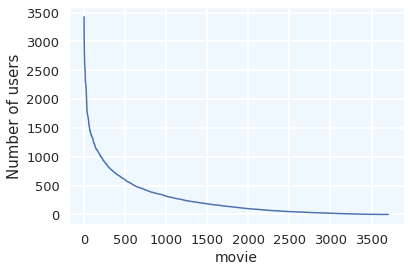

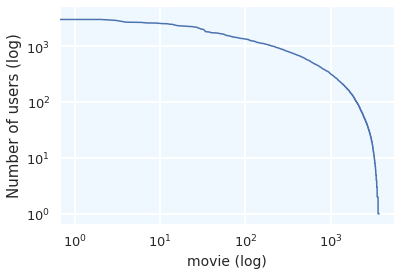

In [13]:
plot_data_distribution(item_dist, item_col)
plot_data_distribution(item_dist, item_col, [False, 0],True)

## E. Popularity in the data

In [14]:
num_top = int(top_fraction * num_items)
top_item_dist = item_dist[:num_top]
print('No. items labeled as "popular": ' + str(len(top_item_dist)))

No. items labeled as "popular": 741


In [15]:
def calculate_popularity(df_events, top_item_dist, item_dist, num_users, user_col, item_col):
    pop_count = [] # number of top items per user
    user_hist = [] # user history sizes
    pop_fraq = [] # relative number of top items per user
    pop_item_fraq = [] # average popularity of items in user profiles
    i=0
    for u, df in df_events.groupby(user_col):
        no_user_items = len(set(df[item_col]))
        no_user_pop_items = len(set(df[item_col]) & set(top_item_dist.index))
        pop_count.append(no_user_pop_items)
        user_hist.append(no_user_items) 
        pop_fraq.append(no_user_pop_items / no_user_items)
        user_pop_item_fraq = sum(item_dist[df[item_col]] / num_users) / no_user_items
        pop_item_fraq.append(user_pop_item_fraq)
        i+=1
        if i%1000==0:
            print(i)
    return pop_count,user_hist,pop_fraq, pop_item_fraq

In [16]:
pop_count,user_hist,pop_fraq, pop_item_fraq = calculate_popularity(df_events, top_item_dist, item_dist, num_users, user_col, item_col)

1000
2000
3000
4000
5000
6000


In [17]:
def plot_popularity_distribution(pop_fraq, item_col, dividing = [False,0]):
    plt.figure()
    ax = plt.axes()
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['left'].set_zorder(0)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    
    ax.set_facecolor("aliceblue")
    plt.grid(color = "w",linewidth = 2 )
    if dividing[0]:
        y = range(len(pop_fraq))
        x0 = int(len(y)*dividing[1]) 
        x1 = int(len(y)*(1-dividing[1]))
        x= sorted(pop_fraq)
        plt.plot(y[:x0+1],x[:x0+1], label="Niche users", linewidth = 5)
        plt.plot(y[x0:x1+1],x[x0:x1+1], label = "Diverse users", linewidth = 5)
        plt.plot(y[x1:],x[x1:], label = "Blockbuster-focused users", linewidth =5)
    else:
        plt.plot(sorted(pop_fraq))
    plt.xlabel('User', fontsize='15')
    plt.xticks(fontsize='13')
    plt.ylabel('Ratio of popular '+item_col+'s', fontsize='15')
    plt.yticks(fontsize='13')
    plt.axhline(y=0.8, color='black', linestyle='--', label='80% ratio of popular '+item_col+'s')
    plt.legend(fontsize='15')
    plt.show(block=True)

def plot_profile_size_vs_popularity(pop_metric, user_hist, way, item_col):
    plt.figure()
    ax = plt.axes()
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['left'].set_zorder(0)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    
    ax.set_facecolor("aliceblue")
    plt.grid(color = "w",linewidth = 2 )
    slope, intercept, r_value, p_value, std_err = stats.linregress(user_hist, pop_metric)
    print('R-value: ' + str(r_value))
    line = slope * np.array(user_hist) + intercept
    plt.plot(user_hist, pop_metric, 'o', user_hist, line)
    plt.xlabel('User profile size', fontsize='15')
    plt.xticks(fontsize='13')
    if way == "count":
        ylabel = "Number of popular "+item_col+"s"
    elif way == "percentage":
        ylabel = 'Percentage of popular '+item_col+'s'
    else:
        ylabel = "Average popularity of "+item_col+"s"
    plt.ylabel(ylabel, fontsize='15')
    plt.yticks(fontsize='13')
    plt.show(block=True)

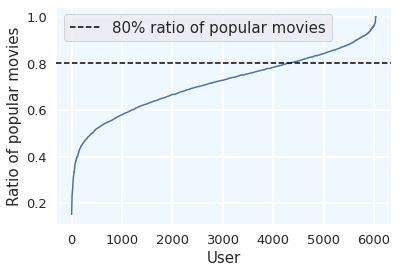

R-value: 0.9662364112421091


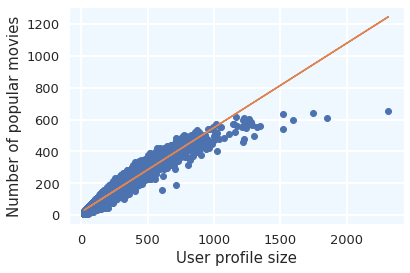

R-value: -0.40259977494843086


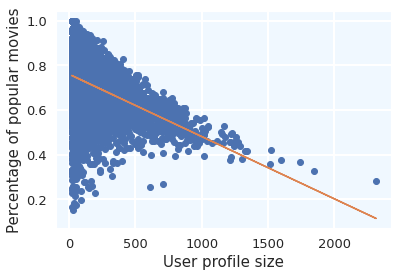

R-value: -0.48167705404310895


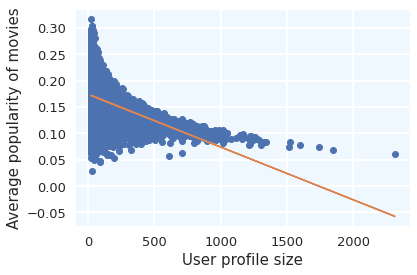

In [18]:
plot_popularity_distribution(pop_fraq, item_col)
plot_profile_size_vs_popularity(pop_count,user_hist, "count", item_col)
plot_profile_size_vs_popularity(pop_fraq,user_hist, "percentage", item_col)
plot_profile_size_vs_popularity(pop_item_fraq,user_hist, "average", item_col)

## F. User groups

In [19]:
def sort_user_dist(user_dist,pop_count, user_hist,pop_fraq,pop_item_fraq, by = "pop_fraq"):
    user_dist = user_dist.sort_index()
    user_dist_sorted = pd.DataFrame(data = user_dist)
    
    user_dist_sorted.columns = ["count"]
    
    user_dist_sorted["pop_count"] = pop_count
    user_dist_sorted["user_hist"] = user_hist
    user_dist_sorted["pop_fraq"] = pop_fraq
    user_dist_sorted["pop_item_fraq"] = pop_item_fraq
    
    user_dist_sorted = user_dist_sorted.sort_values(by=[by])
    return user_dist_sorted

def split(user_dist_sorted, top_fraction):
    low, med, high = np.split(user_dist_sorted, [int(top_fraction*len(user_dist_sorted)), int((1-top_fraction)*len(user_dist_sorted))])
    return low, med, high
def calculate_group_characteristics(low, med, high):
    low_profile_size = low.user_hist.mean()
    med_profile_size = med.user_hist.mean()
    high_profile_size = high.user_hist.mean()
    
    low_nr_users = len(low)
    med_nr_users = len(med)
    high_nr_users = len(high)
    
    low_GAP = low.pop_item_fraq.mean()
    med_GAP = med.pop_item_fraq.mean()
    high_GAP = high.pop_item_fraq.mean()
    
    return low_profile_size, med_profile_size, high_profile_size, low_nr_users, med_nr_users, high_nr_users, low_GAP, med_GAP, high_GAP

### Make notion of popularity propensity choice
The reader has to manually choose how to divide the users into groups according to their propensity for popular items.

In [118]:
popularity_function = {'pop_one': "pop_fraq",
             'pop_two': "pop_item_fraq"}

In [119]:
pop_notion = "pop_two"

In [120]:
user_dist_sorted = sort_user_dist(user_dist,pop_count, user_hist,pop_fraq,pop_item_fraq, by = popularity_function[pop_notion])
low, med, high = split(user_dist_sorted, top_fraction)
low_profile_size, med_profile_size, high_profile_size, low_nr_users, med_nr_users, high_nr_users, low_GAP, med_GAP, high_GAP = calculate_group_characteristics(low, med, high)

In [121]:
print('Niche GAP: ' + str(low_GAP))
print('Diverse GAP: ' + str(med_GAP))
print('Blockbuster-focused GAP: ' + str(high_GAP))

Niche GAP: 0.10553495904535196
Diverse GAP: 0.15506376330643612
Blockbuster-focused GAP: 0.21728886150684454


In [122]:
print(low.pop_fraq.mean(), med.pop_fraq.mean(), high.pop_fraq.mean())

0.5221848457000486 0.7285454150282953 0.8635075963622323


In [123]:
def plot_group_characteristics(low_nr, med_nr, high_nr, way, item_col):
    plt.figure()
    ax = plt.axes()
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['left'].set_zorder(0)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    
    ax.set_facecolor("aliceblue")
    plt.bar(np.arange(3), [low_nr, med_nr, high_nr])
    plt.xticks(np.arange(3), ['Niche', 'Diverse', 'Blockbuster-focused'])
    plt.xlabel('User group')
    if way=="size":
        ylabel = 'Average user profile size'
    else:
        ylabel = "Number of users per group"
    plt.ylabel(ylabel)
    
    print('Niche: ' + str(low_nr))
    print('Diverse: ' + str(med_nr))
    print('Blockbuster-focused: ' + str(high_nr))
    plt.show(block=True)

Niche: 1208
Diverse: 3624
Blockbuster-focused: 1208


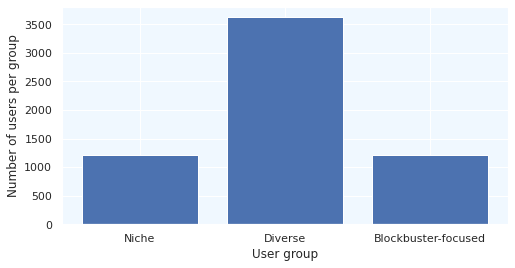

Niche: 336.1076158940397
Diverse: 145.6437637969095
Blockbuster-focused: 54.94867549668874


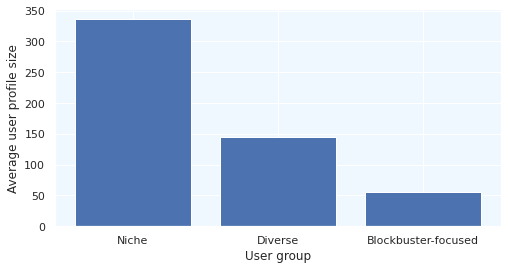

In [124]:
plot_group_characteristics(low_nr_users, med_nr_users, high_nr_users, way = "number", item_col = item_col)
plot_group_characteristics(low_profile_size, med_profile_size, high_profile_size, way = "size", item_col = item_col)

In [125]:
# plot_data_distribution(item_dist, item_col, dividing = [True, top_fraction], log = False)
# plot_popularity_distribution(pop_fraq, item_col, dividing = [True,top_fraction])

## G. Recommendation

In [126]:
df_events.head()

,user,movie,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


### G.1 Cornac
The library used by the book paper. It contains many algorithms.

In [27]:
df_events_cornac = df_events.copy()
mapping_dict = {} # Create a dictionary that maps each movie number to an integer.
i=0
for mov in df_events_cornac[item_col].unique():
    mapping_dict[mov] = i
    i+=1
df_events_cornac[item_col] = df_events_cornac[item_col].map(lambda x: mapping_dict.get(x,x)) # Map in the ratings file

In [28]:
df_events_cornac.user = df_events_cornac.user.astype("string")
df_events_cornac.movie = df_events_cornac.movie.astype("string")

In [29]:
df_item_dist_cornac = df_item_dist.rename(index = mapping_dict)

In [30]:
data = list(df_events_cornac[[user_col,item_col,predict_col]].to_records(index = False))

In [31]:
data[:3]

[('1', '0', 5), ('1', '1', 3), ('1', '2', 3)]

In [32]:
# Split the data based on ratio
rs = RatioSplit(data=data, test_size=test_size, rating_threshold=rating_threshold, seed=123)

In [44]:
all_items = set(range(rs.total_items)) # needed for later

In [46]:
# Define the two different options for UserKNN, with and without mean centering
usKNN = UserKNN(k=40, similarity = 'cosine', mean_centered=False, seed = my_seed, verbose=True)
usKNN_means = UserKNN(k=40, similarity = 'cosine', mean_centered=True, seed = my_seed, verbose=True)

#### Training

In [47]:
# initialize models, here we are comparing: simple, traditional, and neural networks based models
models = [
          # 1: Random
          # 2: MostPop
          MostPop(),
          # 3: UserKNN
          usKNN,
          # 4: ItemKNN
          ItemKNN(k=40, similarity = 'cosine', mean_centered=False, seed = my_seed, verbose=True),
          # 5: UserKNN with means
          usKNN_means,
          ## 6: BaselineOnly
          #BaselineOnly(verbose=True),
          # 7: BPR
          BPR(k=10, max_iter=200, learning_rate=0.001, lambda_reg=0.01, seed=123, verbose=True),
          # 8: MF
          MF(k=30, max_iter=100, learning_rate=0.01, lambda_reg=0.001, seed=123, verbose=True),
          # 9: PMF
          PMF(k=10, max_iter=100, learning_rate=0.001, lambda_reg=0.001, verbose=True),
          # 10: NMF
          CornacNMF(k=15, max_iter=50, learning_rate=0.005, lambda_u=0.06, lambda_v=0.06, lambda_bu=0.02, lambda_bi=0.02, use_bias=False, verbose=True, seed=123),
          # 11: WMF
          WMF(k=50, max_iter=50, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01, verbose=True, seed=123),
          # 12: PF
          HPF(k=50, seed=123, hierarchical=False, name="PF", verbose=True),
          # 13: NueMF
          NeuMF(num_factors=8, layers=[32, 16, 8], act_fn="tanh", num_epochs=1, num_neg=3, batch_size=256, lr=0.001, seed=42, verbose=True),
          # 14: VAECF
          VAECF(k=10, autoencoder_structure=[20], act_fn="tanh", likelihood="mult", n_epochs=100, batch_size=100, learning_rate=0.001, beta=1.0, seed=123, use_gpu=True, verbose=True)
          ]

In [48]:
algo_names = ["Random",
              "MostPop", 
              "UserKNN",
              "ItemKNN", 
              "UserKNN with means", 
              "BPR",
              "MF",
              "PMF",
              "NMF",
              "WMF",
              "HPF",
              "NeuMF",
              "VAECF"
              ] # in the order that they are in the model list

In [49]:
# define metrics to evaluate the models
metrics = [MAE()]

# put it together in an experiment, voilà!
start = time.time()
exp = cornac.Experiment(eval_method=rs, models=models, metrics=metrics, user_based=True)
exp.run()
end = time.time()
print(round(end-start), "seconds.")

  0%|          | 0/6040 [00:00<?, ?it/s]

  0%|          | 0/3679 [00:00<?, ?it/s]

  0%|          | 0/6040 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Learning...
epoch 0, loss: 74507.760548
epoch 1, loss: 58688.467291
epoch 2, loss: 52678.747321
epoch 3, loss: 50128.612106
epoch 4, loss: 48638.692067
epoch 5, loss: 47552.996438
epoch 6, loss: 46602.354238
epoch 7, loss: 45706.298392
epoch 8, loss: 44892.622352
epoch 9, loss: 44200.995179
epoch 10, loss: 43633.593587
epoch 11, loss: 43168.020233
epoch 12, loss: 42778.554078
epoch 13, loss: 42444.117637
epoch 14, loss: 42148.739789
epoch 15, loss: 41880.417563
epoch 16, loss: 41630.244486
epoch 17, loss: 41391.966498
epoch 18, loss: 41161.701966
epoch 19, loss: 40937.535106
epoch 20, loss: 40718.851573
epoch 21, loss: 40505.555427
epoch 22, loss: 40297.467209
epoch 23, loss: 40094.107683
epoch 24, loss: 39894.832368
epoch 25, loss: 39699.116262
epoch 26, loss: 39506.788203
epoch 27, loss: 39318.101294
epoch 28, loss: 39133.630308
epoch 29, loss: 38954.070643
epoch 30, loss: 38780.035466
epoch 31, loss: 38611.921471
epoch 32, loss: 38449.865955
epoch 33, loss: 38

  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!
Learning...
Learning completed!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


TEST:
...
        |    MAE | Train (s) | Test (s)
------- + ------ + --------- + --------
MostPop | 1.2974 |    0.0003 |   3.6990
UserKNN | 0.7669 |    6.6749 |  40.5998
ItemKNN | 0.8037 |    2.1387 |  35.7914
UserKNN | 0.7491 |    6.9488 |  39.7821
BPR     | 2.0852 |   69.5456 |   4.8406
MF      | 0.7904 |    6.7901 |   4.6431
PMF     | 0.7011 |   42.1394 |   5.0813
NMF     | 0.7496 |    4.5562 |   5.1572
WMF     | 1.1277 |   45.7649 |   4.3314
PF      | 2.4691 | 1076.4432 |   4.1696
NeuMF   | 2.7023 |   83.2529 | 121.1546
VAECF   | 2.7023 |  129.6749 | 116.5952

1860 seconds.


#### Ranking and recommendation
We have identified three evaluation strategies:
1. For every user in the **train set** rank **all items**. | Book paper, *eva_one*
2. For every user in the **test set** rank **only the items this user has rated in the test set**. | Music paper, *eva_two*
3. For every user in the **test set** rank **only the items this user has NOT rated in the train set**. | Movie(?) paper, *eva_three*

For every evaluation strategy, we define a function that recommends the appropriate items to the appropriate users as described above. 

##### Functions

In [65]:
def get_top_n_eva_one(algo_name,i, n=10):
  model = exp.models[i]
  print(algo_name + " model is selected:")
  top_n = defaultdict(list)
  for uid in tqdm(model.train_set.uid_map.values()): # every user in the train set
    user_id = list(model.train_set.user_ids)[uid]
    item_rank = model.rank(user_idx=uid)[0] # all
    # collect top N items
    item_rank_top = item_rank[:n]
    for iid in item_rank_top:
      item_id = list(model.train_set.item_ids)[iid]
      top_n[int(user_id)].append((int(item_id), model.score(uid, iid)))
  return top_n

In [51]:
def get_top_n_eva_two(algo_name,i, n=10):
  model = exp.models[i]
  print(algo_name + " model is selected:")
  top_n = defaultdict(list)
  for uid in tqdm(rs.test_set.uid_map.values()): # every user in the test set
    user_id = list(rs.train_set.user_ids)[uid]
    user_items_in_the_test_set = rs.test_set.user_data[uid][0] 
    
    item_rank = model.rank(user_idx=uid, item_indices = user_items_in_the_test_set)[0] # items the user has rated in the test set 
    item_rank_top = item_rank[:n]
    for iid in item_rank_top:
      item_id = list(model.train_set.item_ids)[iid]
      top_n[int(user_id)].append((int(item_id), model.score(uid, iid)))
  return top_n

In [52]:
def get_top_n_eva_three(algo_name,i, n=10):
  model = exp.models[i]
  print(algo_name + " model is selected:")
  top_n = defaultdict(list)

  for uid in tqdm(rs.test_set.uid_map.values()): # every user in the test set
    user_id = list(rs.train_set.user_ids)[uid]
    user_items_in_the_train_set = set(rs.train_set.user_data[uid][0])
    user_items_not_in_the_train_set = list(all_items.difference(user_items_in_the_train_set))
    
    item_rank = model.rank(user_idx=uid, item_indices = user_items_not_in_the_train_set)[0] # items the user has NOT rated in the TRAIN set
    item_rank_top = item_rank[:n]
    for iid in item_rank_top:
      item_id = list(model.train_set.item_ids)[iid]
      top_n[int(user_id)].append((int(item_id), model.score(uid, iid)))
  return top_n

In [53]:
# random recommendation algorithm, same for every strategy 
def get_top_n_random(n=10):
    print("Random model is selected:")
    top_n = defaultdict(list)

    for uid in tqdm(rs.test_set.uid_map.values()): # every user in the test set
      if uid not in top_n.keys():
        user_id = list(rs.train_set.user_ids)[uid]
        user_items_in_the_train_set = set(rs.train_set.user_data[uid][0])
        user_items_not_in_the_train_set = list(all_items.difference(user_items_in_the_train_set)) # random choice out of the items that the user has NOT rated in the train set
        for i in range(0, n):
          top_n[int(user_id)].append((int(rd.choice(user_items_not_in_the_train_set)), i))
          
    return top_n

##### Recommendation

Choose evaluation strategy.

In [127]:
evaluation_function = {'eva_one':get_top_n_eva_one,
             'eva_two': get_top_n_eva_two,
             'eva_three': get_top_n_eva_three}

In [128]:
choice = 'eva_one'
# to be manually set!!! 

In [129]:
i = 0
low_rec_gap_list = [] # one entry per algorithm
medium_rec_gap_list = []
high_rec_gap_list = []

for i in range(0, len(algo_names)):
    df_item_dist_cornac[algo_names[i]] = 0
    low_rec_gap = 0
    medium_rec_gap = 0
    high_rec_gap = 0
    
    if algo_names[i] == 'Random':
      top_n = get_top_n_random(n=10)
    else:
      top_n = evaluation_function[choice](algo_names[i],i-1, n=10)
    low_count = 0
    med_count = 0
    high_count = 0
    for uid, user_ratings in tqdm(top_n.items()):
        iid_list = []
        for (iid, _) in user_ratings:
            df_item_dist_cornac.loc[iid, algo_names[i]] += 1
            iid_list.append(iid)
        gap = sum(df_item_dist_cornac["count"].loc[iid_list]) / len(iid_list)
        if uid in low.index:
            low_rec_gap += gap
            low_count += 1
        elif uid in med.index:
            medium_rec_gap += gap
            med_count += 1
        elif uid in high.index:
            high_rec_gap += gap
            high_count += 1
        else:
          print("hi")
    low_rec_gap_list.append(low_rec_gap / low_count)
    medium_rec_gap_list.append(medium_rec_gap / med_count)
    high_rec_gap_list.append(high_rec_gap / high_count)
    i += 1 # next algorithm

Random model is selected:


100%|██████████| 3815/3815 [00:13<00:00, 288.18it/s]


MostPop model is selected:


100%|██████████| 6040/6040 [00:20<00:00, 291.53it/s]


UserKNN model is selected:


100%|██████████| 6040/6040 [00:20<00:00, 290.78it/s]


ItemKNN model is selected:


100%|██████████| 6040/6040 [00:23<00:00, 258.44it/s]


UserKNN with means model is selected:


100%|██████████| 6040/6040 [00:20<00:00, 289.78it/s]


BPR model is selected:


100%|██████████| 6040/6040 [00:20<00:00, 289.21it/s]


MF model is selected:


100%|██████████| 6040/6040 [00:21<00:00, 284.88it/s]


PMF model is selected:


100%|██████████| 6040/6040 [00:24<00:00, 250.16it/s]


NMF model is selected:


100%|██████████| 6040/6040 [00:21<00:00, 284.90it/s]


WMF model is selected:


100%|██████████| 6040/6040 [00:21<00:00, 279.94it/s]


HPF model is selected:


100%|██████████| 6040/6040 [00:23<00:00, 253.58it/s]


NeuMF model is selected:


100%|██████████| 6040/6040 [00:21<00:00, 279.30it/s]


VAECF model is selected:


100%|██████████| 6040/6040 [00:23<00:00, 256.23it/s]


### Cornac results.

In [130]:
# sns.set(rc = {'figure.figsize':(5,4)})
# for i in range(0, len(algo_names)):
#     plt.figure()
#     x = df_item_dist_cornac["count"]
#     y = df_item_dist_cornac[algo_names[i]]

#     plt.plot(x, y, 'o')
#     plt.title(algo_names[i])
#     plt.xlabel('Movie popularity', fontsize='15')
#     plt.ylabel('Recommendation frequency', fontsize='15')
#     plt.xticks(fontsize='13')
#     plt.yticks(fontsize='13')

In [131]:
low_gap_vals = []
medium_gap_vals = []
high_gap_vals = []

for i in range(0, len(algo_names)):
    low_gap_vals.append((low_rec_gap_list[i] - low_GAP) / low_GAP * 100)
    medium_gap_vals.append((medium_rec_gap_list[i] - med_GAP) / med_GAP * 100)
    high_gap_vals.append((high_rec_gap_list[i] - high_GAP) / high_GAP * 100)

In [132]:
# sns.set(rc = {'figure.figsize':(8,4)})

# # set width of bar
# barWidth = 0.07

# # set height of bar

# bars = {}
# for i in range(len(algo_names)):
#     bars["bars{0}".format(i+1)] = [low_gap_vals[i], medium_gap_vals[i], high_gap_vals[i]]

# # Set position of bar on X axis

# r = {}
# r["r1"] = np.arange(len(bars["bars1"]))

# for i in range(len(algo_names)-1):
#     r["r{0}".format(i+2)] = [x + barWidth for x in r["r{0}".format(i+1)]]

# patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*", "--", "*o",".!."]

# # Make the plot
# for i in range(len(algo_names)):
#   plt.bar(r["r{0}".format(i+1)], bars["bars{0}".format(i+1)], width=barWidth, label=algo_names[i], hatch=patterns[i])

# # Add xticks on the middle of the group bars + show legend
# plt.xlabel('User group', fontsize='14')
# plt.ylabel('% $\Delta$ GAP', fontsize='14')
# plt.xticks([r + barWidth + 0.3 for r in range(len(bars["bars1"]))], ['Niche', 'Diverse', 'Blockbuster-focused'], fontsize='13')
# plt.yticks(fontsize='10')
# plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., framealpha=1, fontsize='12')
# plt.show()

# Save!!

In [133]:
from google.colab import files
import pickle as pkl

In [68]:
df_item_dist_cornac.to_csv('df_item_dist_cornac_movies_'+choice+'.csv') 
files.download('df_item_dist_cornac_movies_'+choice+'.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [134]:
with open('low_gap_vals_movies_'+choice+'_'+pop_notion+'.pickle', 'wb') as handle:
    pkl.dump(low_gap_vals, handle)
files.download('low_gap_vals_movies_'+choice+'_'+pop_notion+'.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [135]:
with open('med_gap_vals_movies_'+choice+'_'+pop_notion+'.pickle', 'wb') as handle:
    pkl.dump(medium_gap_vals, handle)
files.download('med_gap_vals_movies_'+choice+'_'+pop_notion+'.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [136]:
with open('high_gap_vals_movies_'+choice+'_'+pop_notion+'.pickle', 'wb') as handle:
    pkl.dump(high_gap_vals, handle)
files.download('high_gap_vals_movies_'+choice+'_'+pop_notion+'.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### G.2 Surprise

In [ ]:
print('Min rating: ' + str(df_events[predict_col].min()))
print('Max rating: ' + str(df_events[predict_col].max()))

Min rating: 1
Max rating: 5


In [ ]:
for col in df_events.columns:
  if (col!="user") and (col!=predict_col) and (col!=item_col):
    df_events_surprise = df_events.drop(col, axis=1)

In [ ]:
df_events_surprise.head()

,user,movie,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [ ]:
reader = SurpriseReader(rating_scale=(df_events_surprise[predict_col].min(), df_events_surprise[predict_col].max()))

In [ ]:
data = Dataset.load_from_df(df_events_surprise, reader)

In [ ]:
trainset, testset = train_test_split(data, test_size = test_size, random_state = my_seed)

In [ ]:
len(np.unique([x[0] for x in testset])) # EYSSSSS

6034

In [ ]:
#%%
def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

def get_top_n_random(testset, item_dist, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r in testset:
        if len(top_n[uid]) == 0:
            for i in range(0, 10):
                top_n[uid].append((rd.choice(item_dist.index), i))
    return top_n



def get_top_n_mp(testset, item_dist, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r in testset:
        if len(top_n[uid]) == 0:
            for iid, count in item_dist[:n].items():
                top_n[uid].append((iid, count))
    return top_n

In [ ]:
df_item_dist_surprise, low_rec_gap_list_surprise, medium_rec_gap_list_surprise, high_rec_gap_list_surprise = train_algorithms_surprise(df_item_dist, trainset, testset, item_dist, num_users, low, med, high)

~~~~~~~~~~~~~~~~NEW~~~~~~~~~~~~~~~~~
It took 22.0 seconds.
~~~~~~~~~~~~~~~~NEW~~~~~~~~~~~~~~~~~
It took 21.0 seconds.
~~~~~~~~~~~~~~~~NEW~~~~~~~~~~~~~~~~~
Estimating biases using als...
UserItemAvg
It took 30.0 seconds.
~~~~~~~~~~~~~~~~NEW~~~~~~~~~~~~~~~~~
Computing the cosine similarity matrix...
Done computing similarity matrix.
UserKNN
It took 293.0 seconds.
~~~~~~~~~~~~~~~~NEW~~~~~~~~~~~~~~~~~
Computing the cosine similarity matrix...
Done computing similarity matrix.
UserKNNAvg
It took 130.0 seconds.
~~~~~~~~~~~~~~~~NEW~~~~~~~~~~~~~~~~~
Computing the cosine similarity matrix...
Done computing similarity matrix.
NMF
It took 288.0 seconds.
~~~~~~~~~~~~~~~~NEW~~~~~~~~~~~~~~~~~
SVDpp
It took 92.0 seconds.


In [ ]:
def train_algorithms_surprise(df_item_dist, trainset, testset, item_dist, no_users, low_users, medium_users, high_users):
    sim_users = {'name': 'cosine', 'user_based': True}  # compute cosine similarities between users
    # είδος αποστασης=κοσαιν, ειδος κνν = χρηστη
    algos = [] # Random and MostPopular is calculated by default
    algos.append(None)#Random())
    algos.append(None)#MostPopular())
    algos.append(BaselineOnly()) #αυτο το UserItemAvg, τι ειναι?
    algos.append(KNNBasic(sim_options = sim_users, k=40)) 
    algos.append(KNNBasic(sim_options = {'name': 'cosine', 'user_based': False}, k=40)) 
    algos.append(KNNWithMeans(sim_options = sim_users, k=40)) 
    algos.append(SurpriseNMF(n_factors = 15))
    algos.append(SVDpp(n_factors = 15))
    algo_names = ['Random',
                  'MostPopular',
                  'UserItemAvg',
                  'UserKNN',
                  #"ItemKNN",
                  'UserKNNAvg',
                  'NMF',
                  'SVDpp']
    
    i = 0
    low_rec_gap_list = [] # one entry per algorithmus
    medium_rec_gap_list = []
    high_rec_gap_list = []
    start = time.time()
    for i in range(0, len(algo_names)): #για καθε αλγοριθμο
        print("~~~~~~~~~~~~~~~~NEW~~~~~~~~~~~~~~~~~")
        df_item_dist[algo_names[i]] = 0 #προσθετω στηλη στο ποπιουλαριτι για τον αλγοριθμο i 
        low_rec_gap = 0
        medium_rec_gap = 0
        high_rec_gap = 0
        
        # get accuracy for personalized approaches
        if algo_names[i] != 'Random' and algo_names[i] != 'MostPopular': #για μη χαζους αλγοριθμους
            algos[i].fit(trainset) #κανεις φιτ
            predictions = algos[i].test(testset) #προβλεπεις
            print(algo_names[i])#λες τελειωσε ο ταδε αλγοριθμος
            #get_mae_of_groups(predictions, low_users, medium_users, high_users) #υπολογιζεις τα λαθη και τα τυπωνεις
        
        # get top-n items and calculate gaps for all algorithms
        # κανεις προτασεις αναλογα τις προβλεψεις
        if algo_names[i] == 'Random':
            top_n = get_top_n_random(testset, item_dist, n=10)
        elif algo_names[i] == 'MostPopular':
            top_n = get_top_n_mp(testset, item_dist, n=10)
        else:
            top_n = get_top_n(predictions, n=10)
        #υπολογιζεις τα gap
        low_count = 0
        med_count = 0
        high_count = 0
        for uid, user_ratings in top_n.items():
            iid_list = []
            for (iid, _) in user_ratings:
                df_item_dist.loc[iid, algo_names[i]] += 1
                iid_list.append(iid)
            gap = sum(item_dist[iid_list] / no_users) / len(iid_list)
            if uid in low_users.index:
                low_rec_gap += gap
                low_count += 1
            elif uid in medium_users.index:
                medium_rec_gap += gap
                med_count += 1
            elif uid in high_users.index:
                high_rec_gap += gap
                high_count += 1
        low_rec_gap_list.append(low_rec_gap / low_count)
        medium_rec_gap_list.append(medium_rec_gap / med_count)
        high_rec_gap_list.append(high_rec_gap / high_count)
        i += 1 # next algorithm
        end = time.time()
        print("It took " + str(np.round(end-start)) + " seconds.")
        start = time.time()
    return df_item_dist, low_rec_gap_list, medium_rec_gap_list, high_rec_gap_list

In [ ]:
#%%
algo_names = ['Random',
                  'MostPopular',
                  'UserItemAvg',
                  'UserKNN',
                  #"ItemKNN",
                  'UserKNNAvg',
                  'NMF',
                  'SVDpp']
for alg in algo_names:
    df_item_dist[alg] = df_item_dist[alg]/n_splits

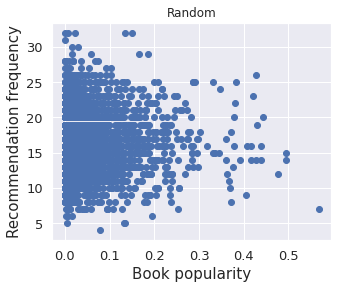

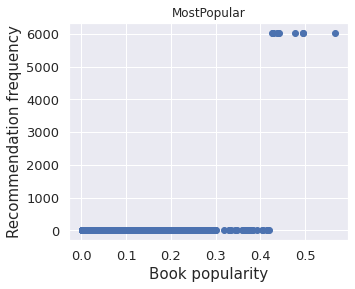

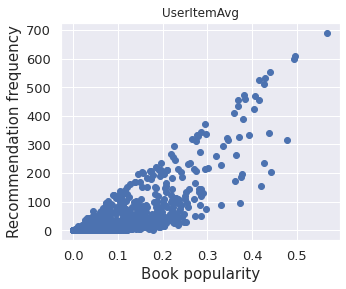

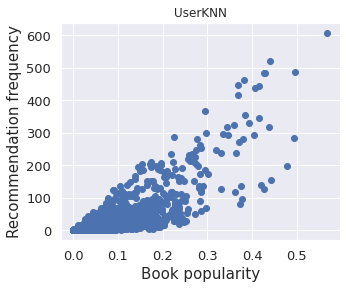

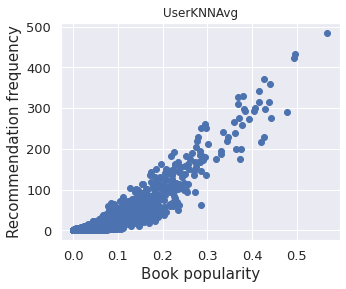

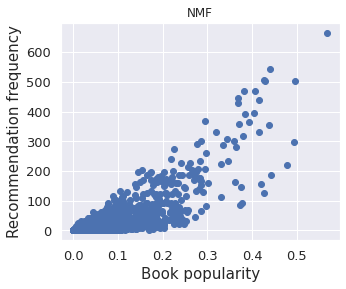

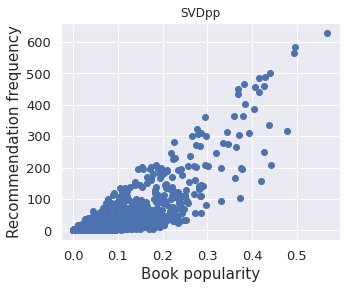

In [ ]:
sns.set(rc = {'figure.figsize':(5,4)})
for i in range(0, len(algo_names)):
    plt.figure()
    x = df_item_dist_surprise["count"]
    y = df_item_dist_surprise[algo_names[i]]

    plt.plot(x, y, 'o')
    plt.title(algo_names[i])
    plt.xlabel('Book popularity', fontsize='15')
    plt.ylabel('Recommendation frequency', fontsize='15')
    plt.xticks(fontsize='13')
    plt.yticks(fontsize='13')

In [ ]:
low_gap_vals = []
medium_gap_vals = []
high_gap_vals = []

for i in range(0, len(algo_names)):
    low_gap_vals.append((low_rec_gap_list_surprise[i] - low_GAP) / low_GAP * 100)
    medium_gap_vals.append((medium_rec_gap_list_surprise[i] - med_GAP) / med_GAP * 100)
    high_gap_vals.append((high_rec_gap_list_surprise[i] - high_GAP) / high_GAP * 100)

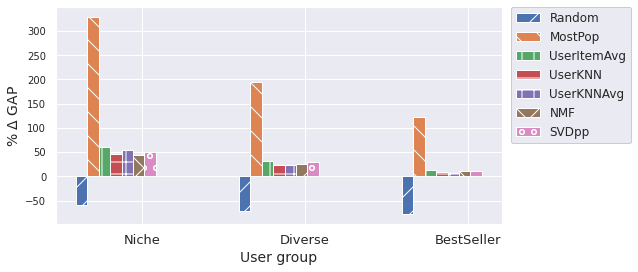

In [ ]:
sns.set(rc = {'figure.figsize':(8,4)})

# set width of bar
barWidth = 0.07

# set height of bar
bars1 = [low_gap_vals[0], medium_gap_vals[0], high_gap_vals[0]]
bars2 = [low_gap_vals[1], medium_gap_vals[1], high_gap_vals[1]]
bars3 = [low_gap_vals[2], medium_gap_vals[2], high_gap_vals[2]]
bars4 = [low_gap_vals[3], medium_gap_vals[3], high_gap_vals[3]]
bars5 = [low_gap_vals[4], medium_gap_vals[4], high_gap_vals[4]]
bars6 = [low_gap_vals[5], medium_gap_vals[5], high_gap_vals[5]]
bars7 = [low_gap_vals[6], medium_gap_vals[6], high_gap_vals[6]]


# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
r7 = [x + barWidth for x in r6]


# algo_names = ['Random',
#                   'MostPopular',
#                   'UserItemAvg',
#                   'UserKNN',
#                   #"ItemKNN",
#                   'UserKNNAvg',
#                   'NMF',
#                   'SVDpp']
patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*", "--"]
# Make the plot
plt.bar(r1, bars1, width=barWidth, label='Random', hatch=patterns[0])
plt.bar(r2, bars2, width=barWidth, label='MostPop', hatch=patterns[1])
plt.bar(r3, bars3, width=barWidth, label='UserItemAvg', hatch=patterns[2])
plt.bar(r4, bars4, width=barWidth, label='UserKNN', hatch=patterns[3])
plt.bar(r5, bars5, width=barWidth, label='UserKNNAvg', hatch=patterns[4])
plt.bar(r6, bars6, width=barWidth, label='NMF', hatch=patterns[5])
plt.bar(r7, bars7, width=barWidth, label='SVDpp', hatch=patterns[6])


# Add xticks on the middle of the group bars + show legend
plt.xlabel('User group', fontsize='14')
plt.ylabel('% $\Delta$ GAP', fontsize='14')
plt.xticks([r + barWidth + 0.3 for r in range(len(bars1))], ['Niche', 'Diverse', 'BestSeller'], fontsize='13')
plt.yticks(fontsize='10')
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., framealpha=1, fontsize='12')
plt.show()